In [1]:
#Imports
import os
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
import pickle
import tqdm
import line_profiler
from operator import itemgetter
%load_ext heat

In [2]:
def track_id_gen(dist, track):
    return track[0:4]+"-"+str(int(dist))

In [3]:
#pickle Load results
resultspicklefile = open( 'results-df.npy', 'rb')
resultsdf = pickle.load(resultspicklefile)
resultsdf = pd.DataFrame(resultsdf)
resultsdf.head()
split_distances = pd.read_csv("split_distance.csv")
resultsdf["dist"] = resultsdf["dist"].astype(str).str[:-1].astype(float)

resultsdf.run_time = resultsdf.run_time.astype(float)
resultsdf["track_id"] = resultsdf.apply(lambda s: track_id_gen(s["dist"],s["track"]), axis=1)
resultsdf_merged = pd.merge(resultsdf, split_distances, on="track_id")

In [4]:
resultsdf_merged

,race_id,date,track_x,dist_x,grade,place,dog_id,box,split_times,split_margins,...,margin,track_id,Unnamed: 0,track_y,dist_y,mean_time,mean_split,split_dist_estim,split_dist,id
0,208756700,01 Apr 17,Ballarat,450.0,Maiden Heat,1.0,1296100098,2,6.73,0.00,...,0,Ball-450,2,Ballarat,450,26.038262,6.791825,117.378074,0,Ball-450
1,208756700,01 Apr 17,Ballarat,450.0,Maiden Heat,2.0,1177320005,3,6.87,0.14,...,0.20,Ball-450,2,Ballarat,450,26.038262,6.791825,117.378074,0,Ball-450
2,208756700,01 Apr 17,Ballarat,450.0,Maiden Heat,3.0,1549980026,5,6.99,0.26,...,1.24,Ball-450,2,Ballarat,450,26.038262,6.791825,117.378074,0,Ball-450
3,208756700,01 Apr 17,Ballarat,450.0,Maiden Heat,4.0,1474670055,7,6.88,0.15,...,2.79,Ball-450,2,Ballarat,450,26.038262,6.791825,117.378074,0,Ball-450
4,208756700,01 Apr 17,Ballarat,450.0,Maiden Heat,5.0,913850094,8,6.91,0.18,...,3.60,Ball-450,2,Ballarat,450,26.038262,6.791825,117.378074,0,Ball-450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449962,224547720,30 May 17,Warragul,680.0,Special Event,3.0,954250096,2,18.15,0.00,...,4.17,Warr-680,48,Warragul,680,39.893460,18.804604,320.532003,0,Warr-680
449963,224547720,30 May 17,Warragul,680.0,Special Event,4.0,1428630000,3,19.10,0.95,...,5.44,Warr-680,48,Warragul,680,39.893460,18.804604,320.532003,0,Warr-680
449964,224547720,30 May 17,Warragul,680.0,Special Event,5.0,-743571,4,18.83,0.68,...,5.80,Warr-680,48,Warragul,680,39.893460,18.804604,320.532003,0,Warr-680
449965,224547720,30 May 17,Warragul,680.0,Special Event,6.0,-748349,6,19.03,0.88,...,10.23,Warr-680,48,Warragul,680,39.893460,18.804604,320.532003,0,Warr-680


In [4]:
def input_layer_gen(form):
    race_forms = form.groupby(["race_id"])
    for i,j in race_forms:
        print(i,j)
        break

In [5]:
#pickle Load results
resultspicklefile = open( 'results-df.npy', 'rb')
resultsdf = pickle.load(resultspicklefile)
resultsdf = pd.DataFrame(resultsdf)
resultsdf.head()
split_distances = pd.read_csv("split_distance.csv")
resultsdf["dist"] = resultsdf["dist"].astype(str).str[:-1].astype(float)

resultsdf.run_time = resultsdf.run_time.astype(float)
resultsdf["track_id"] = resultsdf.apply(lambda s: track_id_gen(s["dist"],s["track"]), axis=1)
resultsdf_merged = pd.merge(resultsdf, split_distances, on="track_id")


resultsdf_merged["date"] = pd.to_datetime(resultsdf_merged["date"], format="%d %b %y")
resultsdf_merged["speed"] = pd.to_numeric(resultsdf_merged["run_time"])/pd.to_numeric(resultsdf_merged["dist_x"])
resultsdf_merged["split_speed"] = pd.to_numeric(resultsdf_merged["split_times"])/pd.to_numeric(resultsdf_merged["split_dist_estim"])
resultsdf_merged["box"] = pd.to_numeric(resultsdf_merged["box"])
resultsdf_merged["margin"] = pd.to_numeric(resultsdf_merged["margin"])
resultsdf_merged

form = resultsdf_merged
race_forms = form.groupby(["race_id"])
print(race_forms)
race_input_layer = []
race_classes = []


for i,j in tqdm.tqdm(race_forms):
    try:
        race_date = pd.to_datetime(j["date"].iloc[0])
        #print(f"{race_date=}")
        dogs = j.dog_id
        #print(f"race id {i=}")
        race_dist = j.dist_x.iloc[1]
        dog_info = []
        i = 0
        for dog in dogs:
            #print(f"{dog=}")

            prev_form = form[(form.dog_id == dog)&(form["date"]< race_date)]
            dog_speed_avg = prev_form.speed.mean()
            dog_speed_sd = prev_form.speed.std()
            dog_speed_max = prev_form.speed.max()
            dog_split_avg = prev_form.split_speed.mean()
            dog_split_sd = prev_form.split_speed.std()
            dog_split_max = prev_form.split_speed.max()
            dog_margin_mean = prev_form.margin.mean()
            dog_margin_sd = prev_form.margin.std()
            dog_race_count = prev_form.shape[0]
            dog_box = j.box.iloc[i]
            dog_stats = (dog, [dog_box,dog_speed_avg,dog_speed_sd,dog_speed_max,dog_split_avg,dog_split_sd,dog_split_max,dog_margin_mean,dog_margin_sd,dog_race_count], j.place.iloc[i])
            dog_info.append(dog_stats)
            #print(f"{dog_stats=}")
            i = i+1
        dog_info.sort(key=itemgetter(0))
        input_layer = [item for sublist in [x[1] for x in dog_info] for item in sublist]
        classes = [x[2] for x in dog_info]
        race_input_layer.append(input_layer)
        race_classes.append(classes)
    except Exception as e:
        print(f"{e=}")

 88%|████████▊ | 49133/55816 [2:42:02<13:45,  8.09it/s]  

e=IndexError('single positional indexer is out-of-bounds')


100%|██████████| 55816/55816 [3:03:14<00:00,  5.08it/s]  


ipython_cell_input.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prev_form = prev_form[(form.dog_id == dog)]
C:\Users\Nick\.conda\envs\pytorch\lib\site-packages\pyheat\pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


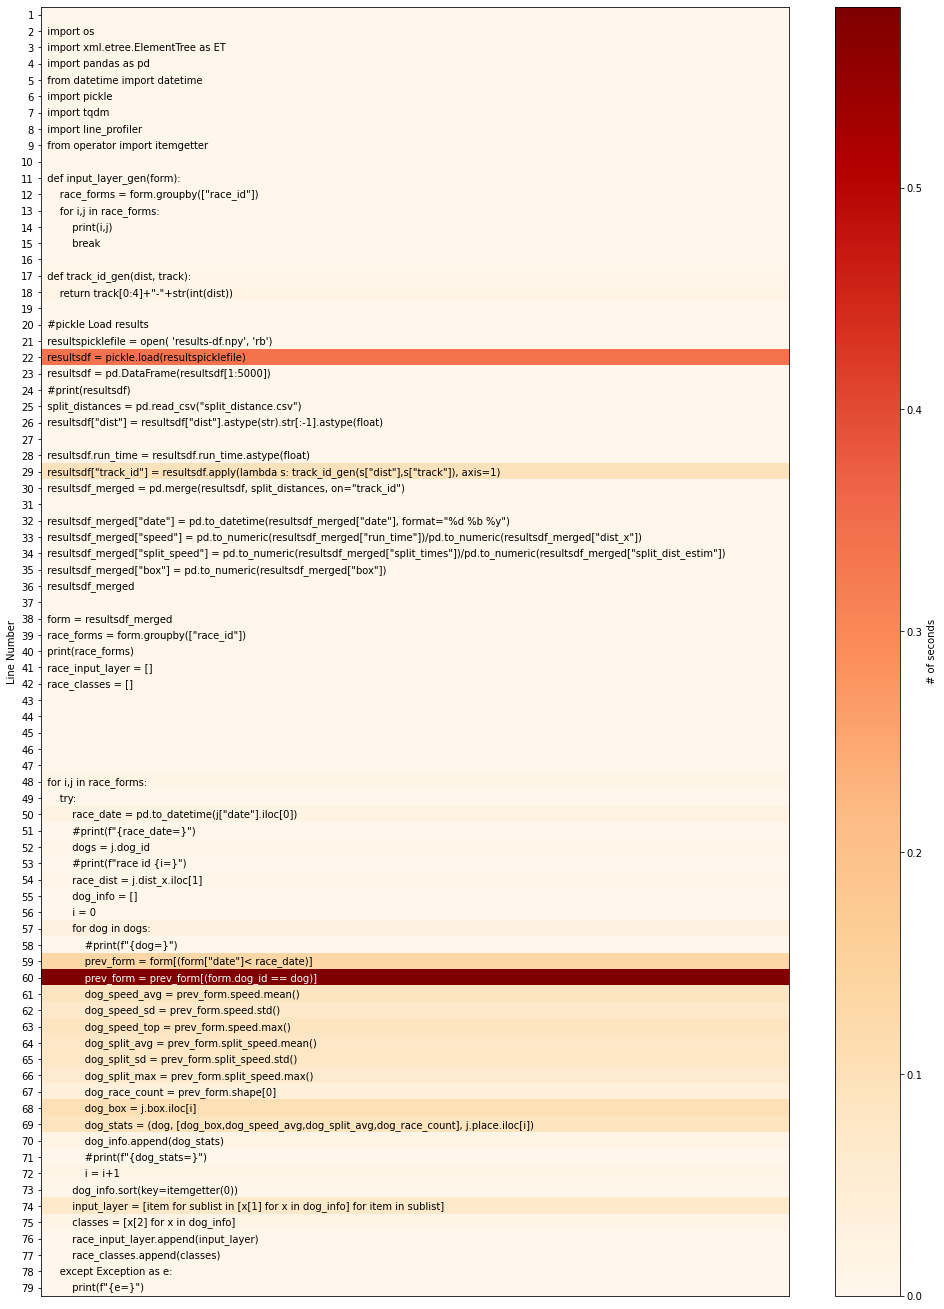

In [17]:
%%heat

import os
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
import pickle
import tqdm
import line_profiler
from operator import itemgetter

def input_layer_gen(form):
    race_forms = form.groupby(["race_id"])
    for i,j in race_forms:
        print(i,j)
        break

def track_id_gen(dist, track):
    return track[0:4]+"-"+str(int(dist))

#pickle Load results
resultspicklefile = open( 'results-df.npy', 'rb')
resultsdf = pickle.load(resultspicklefile)
resultsdf = pd.DataFrame(resultsdf[1:5000])
#print(resultsdf)
split_distances = pd.read_csv("split_distance.csv")
resultsdf["dist"] = resultsdf["dist"].astype(str).str[:-1].astype(float)

resultsdf.run_time = resultsdf.run_time.astype(float)
resultsdf["track_id"] = resultsdf.apply(lambda s: track_id_gen(s["dist"],s["track"]), axis=1)
resultsdf_merged = pd.merge(resultsdf, split_distances, on="track_id")

resultsdf_merged["date"] = pd.to_datetime(resultsdf_merged["date"], format="%d %b %y")
resultsdf_merged["speed"] = pd.to_numeric(resultsdf_merged["run_time"])/pd.to_numeric(resultsdf_merged["dist_x"])
resultsdf_merged["split_speed"] = pd.to_numeric(resultsdf_merged["split_times"])/pd.to_numeric(resultsdf_merged["split_dist_estim"])
resultsdf_merged["box"] = pd.to_numeric(resultsdf_merged["box"])
resultsdf_merged

form = resultsdf_merged
race_forms = form.groupby(["race_id"])
print(race_forms)
race_input_layer = []
race_classes = []





for i,j in race_forms:
    try:
        race_date = pd.to_datetime(j["date"].iloc[0])
        #print(f"{race_date=}")
        dogs = j.dog_id
        #print(f"race id {i=}")
        race_dist = j.dist_x.iloc[1]
        dog_info = []
        i = 0
        for dog in dogs:
            #print(f"{dog=}")
            prev_form = form[(form["date"]< race_date)]
            prev_form = prev_form[(form.dog_id == dog)]
            dog_speed_avg = prev_form.speed.mean()
            dog_speed_sd = prev_form.speed.std()
            dog_speed_top = prev_form.speed.max()
            dog_split_avg = prev_form.split_speed.mean()
            dog_split_sd = prev_form.split_speed.std()
            dog_split_max = prev_form.split_speed.max()
            dog_race_count = prev_form.shape[0]
            dog_box = j.box.iloc[i]
            dog_stats = (dog, [dog_box,dog_speed_avg,dog_split_avg,dog_race_count], j.place.iloc[i])
            dog_info.append(dog_stats)
            #print(f"{dog_stats=}")
            i = i+1
        dog_info.sort(key=itemgetter(0))
        input_layer = [item for sublist in [x[1] for x in dog_info] for item in sublist]
        classes = [x[2] for x in dog_info]
        race_input_layer.append(input_layer)
        race_classes.append(classes)
    except Exception as e:
        print(f"{e=}")

In [6]:
with open("input_list.npy", "wb") as fp:   #Pickling
    
    pickle.dump(race_input_layer, fp)

with open("classes_list.npy", "wb") as fp:   #Pickling
    
    pickle.dump(race_classes, fp)

In [10]:
inputlayer = open( "input_list.npy", 'rb')
inputlayerdf = pickle.load(inputlayer)
inputlayerdf

[[1,
  0.059672102206736355,
  0.0013038454946651171,
  0.06148571428571429,
  0.05890175351276232,
  0.0009527063639297911,
  0.059994277847454834,
  8.902000000000001,
  5.868779259777964,
  5,
  8,
  0.05848506493506494,
  0.0008907936012381001,
  0.06027272727272727,
  0.058515294245794845,
  0.0009500584460310687,
  0.06052134268110914,
  5.381818181818182,
  5.208435116581214,
  11,
  6,
  0.061256388082696595,
  0.0011419304507069529,
  0.06268354430379747,
  0.06081872302453238,
  0.0011619344086033771,
  0.062032575589083185,
  14.535555555555554,
  6.325172154003224,
  9,
  5,
  0.05816878881987578,
  0.0013401291879889708,
  0.059391304347826086,
  0.05788880463785036,
  0.00204291954498698,
  0.06056436558833152,
  5.805000000000001,
  4.601206363552932,
  4,
  2,
  0.05965141007859454,
  0.0006716014707899165,
  0.060310679611650486,
  0.059659061022691785,
  0.0008584861211281845,
  0.0606851668606789,
  10.298333333333334,
  5.331275332100817,
  6,
  7,
  0.0580841402191